In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import galsim

## Installation instructions:

I could not get GalSim to play well with the DSFP default environment. You may have better luck, but the following should be safe:

conda create env -n dsfp-psf numpy scipy astropy matplotlib galsim jupyter -c conda-forge

## Simple functions you may find useful for this exercise.

In [2]:
def createGaussian(nx, ny, xgrid=None, ygrid=None, center = [0,0], sigma = 1.):
    if center is None:
        center = [(nx-1)/2,(ny-1)/2.]
    if xgrid is None:
        xgrid = np.arange(nx)-center[0]
    if ygrid is None:
        ygrid = np.arange(ny) - center[1]
    x2d,y2d = np.meshgrid(xgrid,ygrid)
    r = np.sqrt(x2d**2+y2d**2)
    return 1/np.sqrt(2*np.pi*sigma**2)*np.exp(-r**2/sigma**2/2.)

def createSersic(nx,ny, xgrid=None, ygrid=None,n=0.25, center = [0,0], Re = 1.):
    if center is None:
        center = [(nx-1)/2,(ny-1)/2.]
    if xgrid is None:
        xgrid = np.arange(nx)-center[0]
    if ygrid is None:
        ygrid = np.arange(ny) - center[1]
    x2d,y2d = np.meshgrid(xgrid,ygrid)
    r = np.sqrt(x2d**2+y2d**2)
    b_n = 2*n - 1/3.
    im = np.exp(-b_n*((r/Re)**(1/n)-1))
    nonzero = (r>0) & (r<5*Re)
    im[nonzero] = im[nonzero] * np.arctan((5*Re/r[nonzero])**2-1)
    im[r>= 5*Re] = 0
    return im

def createTopHat(nx,ny,xgrid=None,ygrid=None,center = [0,0], radius = 1.):
    if center is None:
        center = [(nx-1)/2,(ny-1)/2.]
    if xgrid is None:
        xgrid = np.arange(nx)-center[0]
    if ygrid is None:
        ygrid = np.arange(ny) - center[1]

    x2d,y2d = np.meshgrid(xgrid,ygrid)
    r = np.sqrt(x2d**2+y2d**2)
    topHat = np.zeros_like(r)
    topHat[r<= radius] = 1
    return topHat

def imageFFT(image):
    imageFT = np.fft.fftshift(np.fft.fft2(image))
    kx = np.fft.fftshift(np.fft.fftfreq(image.shape[0]))
    ky = np.fft.fftshift(np.fft.fftfreq(image.shape[1]))
    return kx,ky,imageFT
    
def binned_radial_profile(image,xgrid=None,ygrid=None,center=None,bins=None):
    nx,ny = image.shape
    if center is None:
        center = [(nx-1)/2,(ny-1)/2.]
    if xgrid is None:
        xgrid = np.arange(nx)-center[0]
    if ygrid is None:
        ygrid = np.arange(ny) - center[1]
    x2d,y2d = np.meshgrid(xgrid,ygrid)
    r = np.sqrt(x2d**2+y2d**2)
    bin_indices = np.digitize(r.flatten(),bins=bins,right=True)
    r_count = np.bincount(bin_indices,weights=r.flatten())
    p_count = np.bincount(bin_indices,weights=image.flatten())
    bin_membership = np.bincount(bin_indices)
    rmean = r_count * 1./bin_membership
    profile = p_count * 1./bin_membership
    return rmean,profile

## And here's an example of how one might use them.

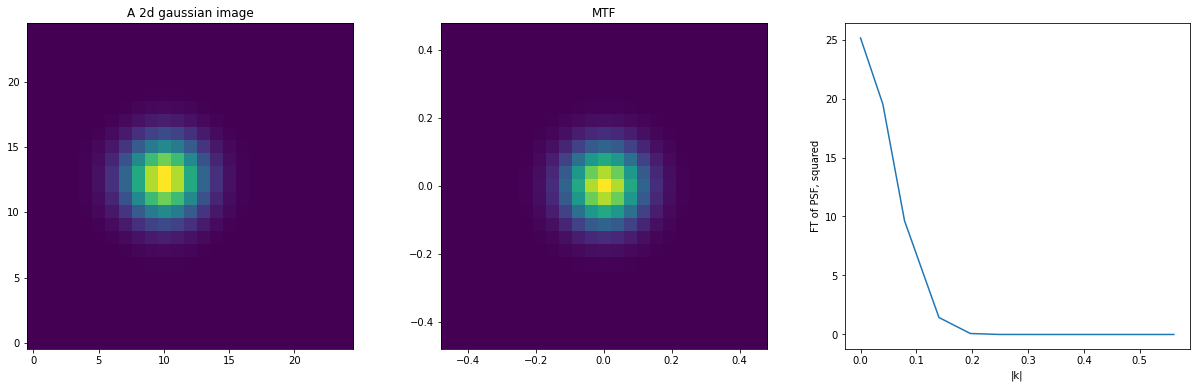

In [3]:
gauss = createGaussian(25,25,center=[10,12.5],sigma=2.)
kx,ky,gaussft = imageFFT(gauss)
kxgrid,kygrid = np.meshgrid(kx,ky)


R,P = binned_radial_profile(np.abs(gaussft)**2,xgrid=kx,ygrid=ky,bins=np.linspace(0,0.5,10))
fig,(ax1,ax2,ax3) = plt.subplots(nrows=1,ncols=3,figsize=(21,6))
ax1.imshow(gauss,origin='lower')
ax1.set_title("A 2d gaussian image")
ax2.imshow(np.abs(gaussft),origin='lower',extent=[np.min(kx),np.max(kx),np.min(ky),np.max(ky)])
ax2.set_title("MTF")
ax3.plot(R,P)
ax3.set_xlabel("|k|")
ax3.set_ylabel("FT of PSF, squared")
plt.show()

## Now let's try to reconstruct a model for the PSF for some simple cases.

Recall, you can get the (ideal) PSF by taking the Fourier transform of the pupil image.

First, let's try it for a telescope with a simple circular aperture.

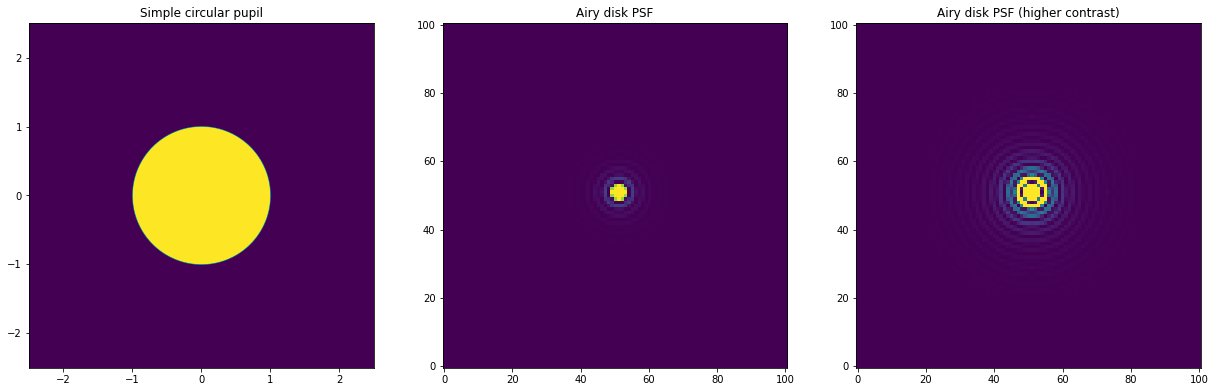

In [18]:
u = np.linspace(-2.5,2.5,2500)
pupil = createTopHat(2500,2500,xgrid=u,ygrid=u,radius=1.)
# Take the Fourier transform of this to get the PSF.
_,_,simplePSFamp = imageFFT(pupil)
simplePSFbig = np.abs(simplePSFamp)**2
center = int((u.size-1)/2)
# There's far too much image here, so cut out the center.
simplePSF = simplePSFbig[center-50:center+51,center-50:center+51]

fig,(ax1,ax2,ax3) = plt.subplots(nrows=1,ncols=3,figsize=(21,7))
ax1.imshow(pupil,origin='lower',extent=[np.min(u),np.max(u),np.min(u),np.max(u)])
ax1.set_title("Simple circular pupil")
ax2.imshow(simplePSF,origin='lower',vmax=0.1*np.max(simplePSF))
ax2.set_title("Airy disk PSF")
ax3.imshow(simplePSF,origin='lower',vmax=0.01*np.max(simplePSF))
ax3.set_title("Airy disk PSF (higher contrast)")
plt.show()

## Problem 1: Construct the PSF of a telescope with a secondary mirror.

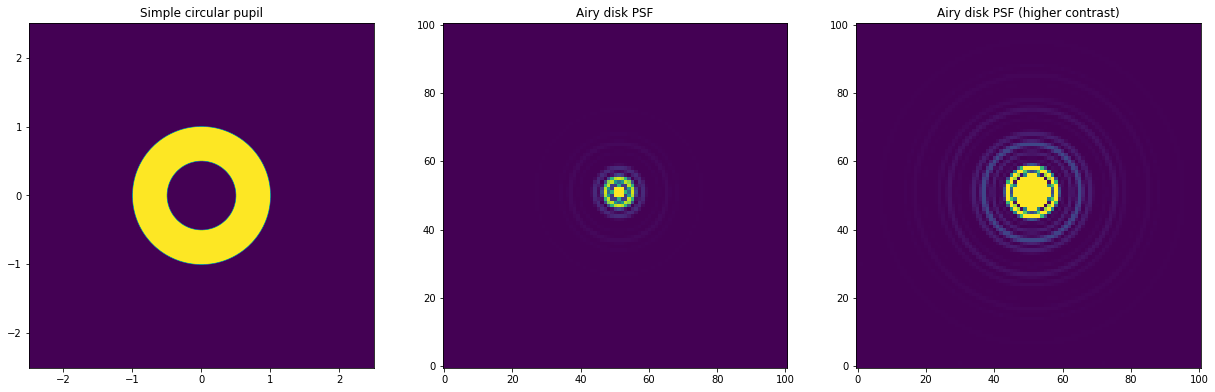

In [19]:
u = np.linspace(-2.5,2.5,2500)
pupil = createTopHat(2500,2500,xgrid=u,ygrid=u,radius=1.) - createTopHat(2500,2500,xgrid=u,ygrid=u,radius=.5)
# Take the Fourier transform of this to get the PSF.
_,_,simplePSFamp = imageFFT(pupil)
simplePSFbig = np.abs(simplePSFamp)**2
center = int((u.size-1)/2)
# There's far too much image here, so cut out the center.
simplePSF = simplePSFbig[center-50:center+51,center-50:center+51]

fig,(ax1,ax2,ax3) = plt.subplots(nrows=1,ncols=3,figsize=(21,7))
ax1.imshow(pupil,origin='lower',extent=[np.min(u),np.max(u),np.min(u),np.max(u)])
ax1.set_title("Simple circular pupil")
ax2.imshow(simplePSF,origin='lower',vmax=0.1*np.max(simplePSF))
ax2.set_title("Airy disk PSF")
ax3.imshow(simplePSF,origin='lower',vmax=0.01*np.max(simplePSF))
ax3.set_title("Airy disk PSF (higher contrast)")
plt.show()

## Problem 2: Add supports

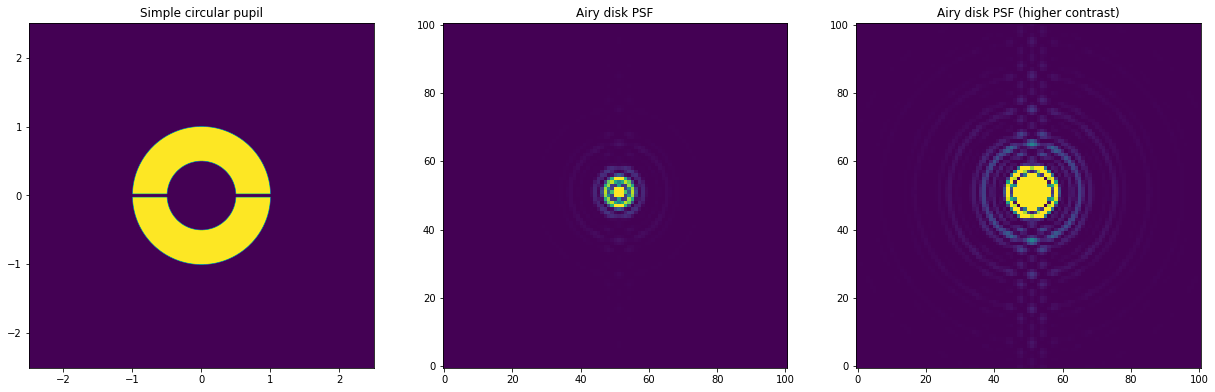

In [21]:
u = np.linspace(-2.5,2.5,2500)
pupil = createTopHat(2500,2500,xgrid=u,ygrid=u,radius=1.) - createTopHat(2500,2500,xgrid=u,ygrid=u,radius=0.5)
pupil[np.abs(u) < 0.025] = 0
# Take the Fourier transform of this to get the PSF.
_,_,simplePSFamp = imageFFT(pupil)
simplePSFbig = np.abs(simplePSFamp)**2
center = int((u.size-1)/2)
# There's far too much image here, so cut out the center.
simplePSF = simplePSFbig[center-50:center+51,center-50:center+51]

fig,(ax1,ax2,ax3) = plt.subplots(nrows=1,ncols=3,figsize=(21,7))
ax1.imshow(pupil,origin='lower',extent=[np.min(u),np.max(u),np.min(u),np.max(u)])
ax1.set_title("Simple circular pupil")
ax2.imshow(simplePSF,origin='lower',vmax=0.1*np.max(simplePSF))
ax2.set_title("Airy disk PSF")
ax3.imshow(simplePSF,origin='lower',vmax=0.01*np.max(simplePSF))
ax3.set_title("Airy disk PSF (higher contrast)")
plt.show()

## Problem 3: Create an n=1 Sersic galaxy. Convolve it with a PSF, and display the result.

## Problem 4a: Determinism and deconvolution.

Note that, so far, everything has been entirely deterministic -- both the Fourier transform and the multiplication are reversible operations. So why can't we just remove the PSF from our telescope image?

Try to reverse the solution to Problem 1, and, starting with the final image, construct and display the de-convolved galaxy image

## Problem 4b: Determinism and deconvolution.

Do the same thing you've done for Problem 4a, but this time add a small amount of noise to the final, psf-convolved galaxy image before you try the deconvolution.

Try to explain the result. 

Hint: you may find it helpful to plot the 1-dimensional radial profiles of some of the simulated quantities you've constructed in Fourier space.